In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#内置的一维精确搜索算法为牛顿法
class Func():
    def __init__(self):
        self.delta = 1e-16
        self.epsilon = 1e-16
        
    def value(self, X: np.array((2,1))):
        return (1-X[0,0])**2+3*(X[1,0]-X[0,0]**2)**2
    
    def grad(self, X: np.array((2,1))):
        x1=-2*(1-X[0,0])-12*X[0,0]*(X[1,0]-X[0,0]**2)
        x2=6*(X[1,0]-X[0,0]**2)
        return np.array([[x1],[x2]])
        
    def hessian(self, X: np.array((2,1))):
        x11=2-12*(X[1,0]-3*X[0,0]**2)
        x12=-12*X[0,0]
        x21=-12*X[0,0]
        x22=6
        return np.array([[x11,x12],[x21,x22]])
    
    def diff_t(self, X: np.array((2,1)), D: np.array((2,1)), t):
        return np.dot(self.grad(X+t*D).T, D)
    
    def diff_2_t(self, X: np.array((2,1)), D: np.array((2,1)), t):
        return np.sum(np.dot(self.hessian(X+t*D).T, D))
    
    def Newton_1D_Method(self, X0: np.array((2,1)), D: np.array((2,1)), delta):#一维精确搜索——牛顿法
        t_tmp=0
        while(abs(self.diff_t(X0,D,t_tmp))>delta):
            t_tmp=t_tmp-self.diff_t(X0,D,t_tmp)/self.diff_2_t(X0,D,t_tmp)
        return X0+t_tmp*D
    
    def Method_0618(self, X0: np.array((2,1)), D: np.array((2,1)), delta):#一维精确搜索——0.618法
        gamma = 1
        t_tmp=0
        ini_diff = self.diff_t(X0, D, t_tmp)
        ini_value = self.value(X0+t_tmp*D)
        if(abs(ini_diff)<=delta):
            return X0+t_tmp*D
        elif(ini_diff<0):
            gamma = 1
        else:
            gamma = -1
            
        while(self.value(X0+(t_tmp + gamma)*D)<ini_value):
            gamma = 2*gamma
        
        a_tmp = t_tmp
        b_tmp = t_tmp + gamma
        eps = 1e-16
        while(abs(a_tmp-b_tmp)>eps):
            a_0618 = (0.618*a_tmp+(1-0.618)*b_tmp)
            b_0618 = (0.618*b_tmp+(1-0.618)*a_tmp)
            if(self.value(X0+a_0618*D)>self.value(X0+b_0618*D)):
                a_tmp = a_0618
            else:
                b_tmp = b_0618
        t_tmp = (a_tmp+b_tmp)/2
        
        return X0+t_tmp*D
    
    def L1NormMethod(self, X0: np.array((2,1)), epsilon):#L1范数下降
        X_tmp=X0
        X_list=[X_tmp]
        X_value_list=[self.value(X_tmp)]
        while(np.dot(self.grad(X_tmp).T, self.grad(X_tmp))>epsilon):
            graditude = np.abs(self.grad(X_tmp))
            D_tmp=-(graditude//np.max(graditude))*self.grad(X_tmp)
            X_tmp=self.Method_0618(X_tmp, D_tmp, self.delta)
            X_list.append(X_tmp)
            X_value_list.append(self.value(X_tmp))
        return X_list, X_value_list, X_tmp, self.value(X_tmp)
    
    def L2NormMethod(self, X0: np.array((2,1)), epsilon):#L2范数下降
        X_tmp=X0
        X_list=[X_tmp]
        X_value_list=[self.value(X_tmp)]
        while(np.dot(self.grad(X_tmp).T, self.grad(X_tmp))>epsilon):
            D_tmp = -self.grad(X_tmp)
            X_tmp=self.Method_0618(X_tmp, D_tmp, self.delta)
            X_list.append(X_tmp)
            X_value_list.append(self.value(X_tmp))
        return X_list, X_value_list, X_tmp, self.value(X_tmp)
    
    def LInfinityNormMethod(self, X0: np.array((2,1)), epsilon):#L∞范数下降
        X_tmp=X0
        X_list=[X_tmp]
        X_value_list=[self.value(X_tmp)]
        while(np.dot(self.grad(X_tmp).T, self.grad(X_tmp))>epsilon):
            graditude = self.grad(X_tmp)
            D_tmp=-(graditude+1e-64)/np.abs(graditude+1e-64)  #为了防止出现 0/0
            X_tmp=self.Method_0618(X_tmp, D_tmp, self.delta)
            X_list.append(X_tmp)
            X_value_list.append(self.value(X_tmp))
        return X_list, X_value_list, X_tmp, self.value(X_tmp)
    
    def FRMethod(self, X0: np.array((2,1)), epsilon):#FR共轭梯度下降
        X_tmp=X0
        X_list=[X_tmp]
        X_value_list=[self.value(X_tmp)]
        X_pre=None
        k=0
        n=2
        while(np.dot(self.grad(X_tmp).T, self.grad(X_tmp))>epsilon):
            graditude = self.grad(X_tmp)
            if(k%n==0):
                D_tmp=-graditude
            else:
                D_tmp=-graditude+np.dot(self.grad(X_tmp).T,self.grad(X_tmp))/np.dot(self.grad(X_pre).T,self.grad(X_pre))*D_tmp
            X_pre=X_tmp
            X_tmp=self.Method_0618(X_tmp, D_tmp, self.delta)
            X_list.append(X_tmp)
            X_value_list.append(self.value(X_tmp))
            k+=1
        return X_list, X_value_list, X_tmp, self.value(X_tmp)
    
    def PRMethod(self, X0: np.array((2,1)), epsilon):#PR共轭梯度下降
        X_tmp=X0
        X_list=[X_tmp]
        X_value_list=[self.value(X_tmp)]
        X_pre=None
        k=0
        n=2
        while(np.dot(self.grad(X_tmp).T, self.grad(X_tmp))>epsilon):
            graditude = self.grad(X_tmp)
            if(k%n==0):
                D_tmp=-graditude
            else:
                D_tmp=-graditude+np.dot(self.grad(X_tmp).T,(self.grad(X_tmp)-self.grad(X_pre)))/np.dot(self.grad(X_pre).T,self.grad(X_pre))*D_tmp
            X_pre=X_tmp
            X_tmp=self.Method_0618(X_tmp, D_tmp, self.delta)
            X_list.append(X_tmp)
            X_value_list.append(self.value(X_tmp))
            k+=1
        return X_list, X_value_list, X_tmp, self.value(X_tmp)

In [3]:
X0 = np.array([[0],[0]])
epsilon = 1e-8
func=Func()
X_list1, X_value_list1, X1, value1 = func.L1NormMethod(X0, epsilon)
X_list2, X_value_list2, X2, value2 = func.L2NormMethod(X0, epsilon)
X_list3, X_value_list3, X3, value3 = func.LInfinityNormMethod(X0, epsilon)


In [4]:
print("L1范数下降法迭代的次数为%d, 最优解为x1 = %.16f, x2 = %.16f, 最优值为%.16f"%(len(X_list1), X1[0,0], X1[1,0], value1))
print("L2范数下降法迭代的次数为%d, 最优解为x1 = %.16f, x2 = %.16f, 最优值为%.16f"%(len(X_list2), X2[0,0], X2[1,0], value2))
print("L∞范数下降法迭代的次数为%d, 最优解为x1 = %.16f, x2 = %.16f, 最优值为%.16f"%(len(X_list3), X3[0,0], X3[1,0], value3))

L1范数下降法迭代的次数为196, 最优解为x1 = 0.9999037455461456, x2 = 0.9997914564138516, 最优值为0.0000000100371442
L2范数下降法迭代的次数为196, 最优解为x1 = 0.9999037561582416, x2 = 0.9997914794722023, 最优值为0.0000000100349247
L∞范数下降法迭代的次数为128, 最优解为x1 = 0.9998978226032315, x2 = 0.9997843018248062, 最优值为0.0000000108269482


In [5]:
def plot_figures(X_list, X_value_list, title):
    def value(x, y):
        return (1-x)**2+3*(y-x**2)**2
    
    X_list = np.concatenate(X_list,axis=1)
    
    plt.figure(figsize = (10,10))
    eps = 1e-2
    n = 2000
    x = np.linspace(np.min(X_list[0,:])-eps, np.max(X_list[0,:])+eps, n)
    y = np.linspace(np.min(X_list[1,:])-eps, np.max(X_list[1,:])+eps, n)
    X, Y = np.meshgrid(x, y)
    plt.contourf(X, Y, value(X, Y), 100, cmap="jet")
    plt.plot(X_list[0,:], X_list[1,:], color = "red", label = "trajectory")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title("Trajectory of "+title)
    plt.show()
    
    plt.figure(figsize = (10,10))
    plt.plot(X_value_list, color = "red", label = "value")
    plt.xlabel("num_iterations")
    plt.ylabel("value")
    plt.legend()
    plt.title("Objective Function Value of "+title)
    plt.show()

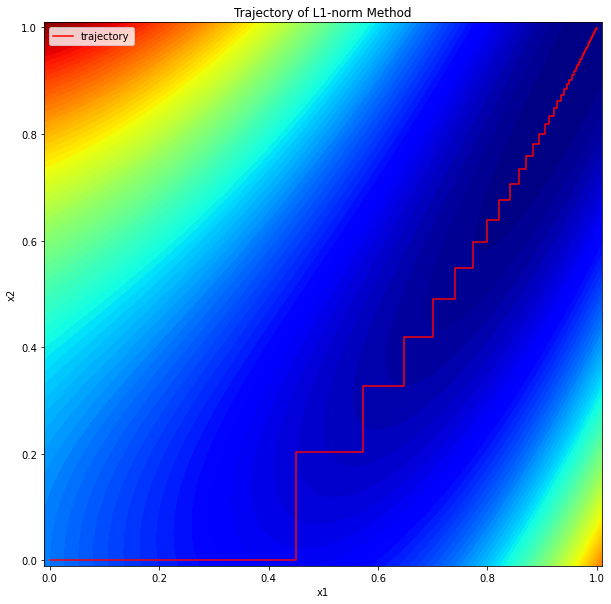

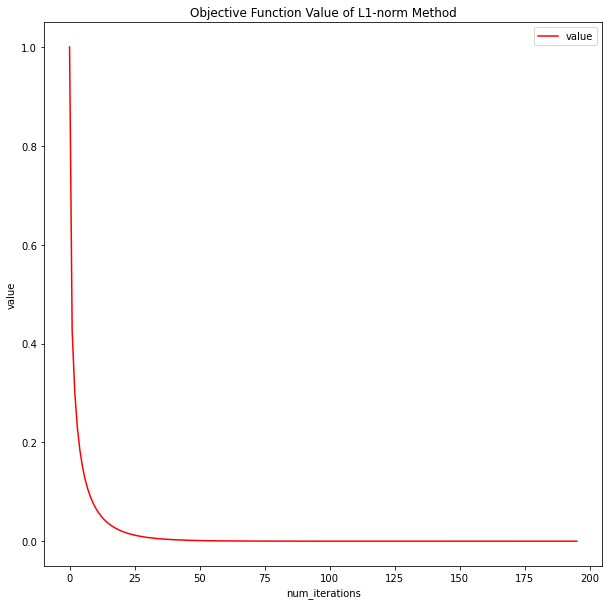

In [6]:
plot_figures(X_list1, X_value_list1, title = "L1-norm Method")

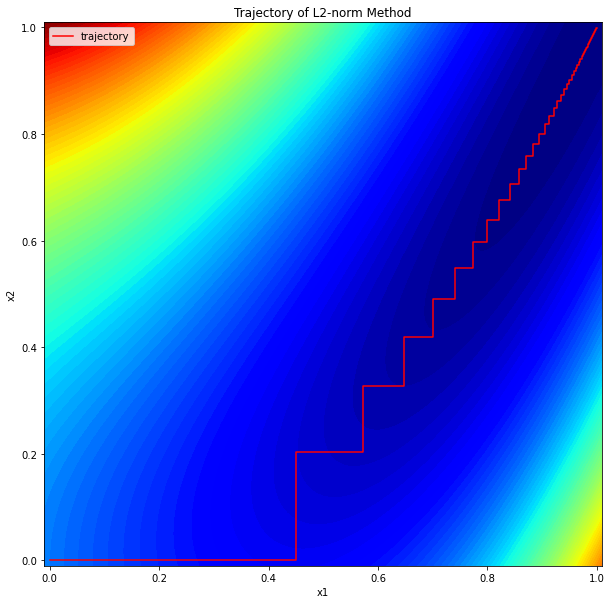

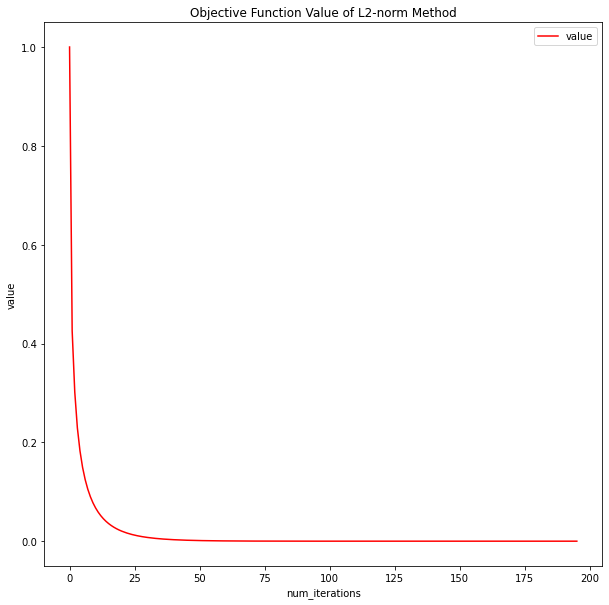

In [7]:
plot_figures(X_list2, X_value_list2, title = "L2-norm Method")

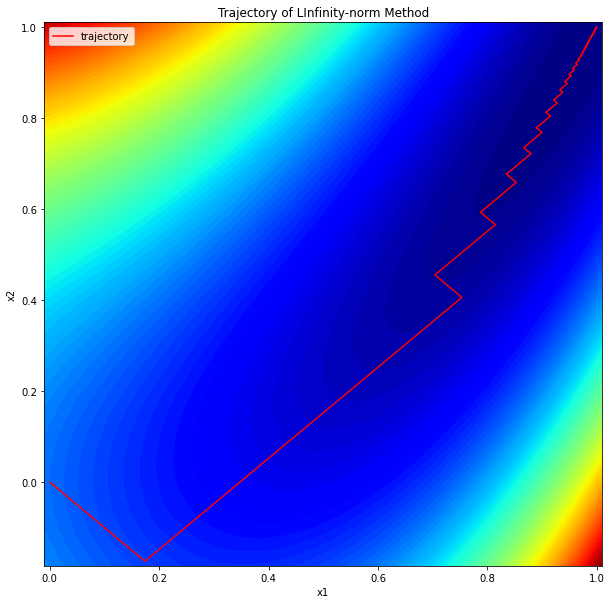

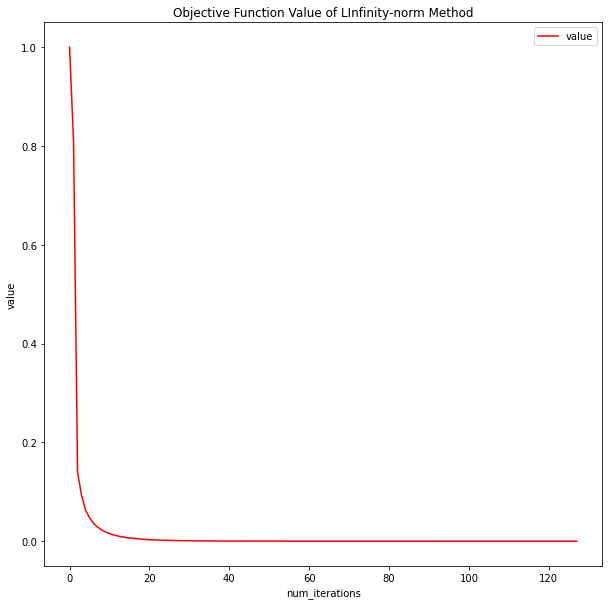

In [8]:
plot_figures(X_list3, X_value_list3, title = "LInfinity-norm Method")